# Image generation with VQ-VAE-2 and GPT2 Transformer



Date : March 2022

Author : Lisa Giordani

Sources :
-  
- 

In [1]:
env="cluster" # "kaggle" or "colab" or "cluster"

dataset="dog" # "dog" or "CIFAR"
generation_model="transformer" # "transformer" or "pixelCNN"

## Frameworks

In [2]:
!pip install pytorch-lightning
!pip install transformers

In [3]:
import os
import gc
import random
import numpy as np
import pandas as pd
from math import cos, pi, floor, sin
import xml.etree.ElementTree as ET 
from tqdm import tqdm_notebook
from collections import defaultdict, OrderedDict
import argparse
from argparse import Namespace
import itertools
import pytorch_lightning as pl
import pickle

from sklearn.model_selection import train_test_split
from transformers import GPT2LMHeadModel, GPT2Config

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import is_available, device_count, get_device_name, current_device
import torch.optim as optim 
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader

import shutil
from torchvision.utils import make_grid
from PIL import Image 
import matplotlib.pyplot as plt, zipfile 

In [4]:
class Cudafy(object):

    def __init__(self, device=None):
        if is_available() and device:
            self.device = device
        else:
            self.device = 0

    @staticmethod
    def check_devices():
        for i in range(device_count()):
            print("Found device {}:".format(i), get_device_name(i))
        if device_count() == 0:
            print("No GPU device found")
        else:
            print("Current cuda device is", get_device_name(current_device()))

    def name(self):
        if is_available():
            return get_device_name(self.device)
        return 'Cuda is not available.'

    def put(self, x):
        """Put x on the default cuda device."""
        if is_available():
            return x.to(device=self.device)
        return x

    def __call__(self, x):
        return self.put(x)

    def get(self, x):
        """Get from cpu."""
        if x.is_cuda:
            return x.to(device='cpu')
        return x

In [5]:
cudafy = Cudafy(0)

## Datasets

In [6]:
def load_images(batch_size, train=True):
    while True:
        for data, _ in create_data_loader(batch_size):
            yield data


def create_data_loader(batch_size):
#     mnist = torchvision.datasets.MNIST('./data', train=train, download=True,
#                                        transform=torchvision.transforms.ToTensor())
    ds = torch.utils.data.TensorDataset(torch.Tensor(imagesIntorch), torch.Tensor(np.zeros(nb_images)))
    return torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

### Dog images

In [7]:
if env=="colab" and dataset=="dog":
    from google.colab import drive
    drive.mount('/content/drive')

    images_path = "/content/drive/MyDrive/3A ENSTA/Projet IA/Bases de données/images.tar"
    annotation_path = "/content/drive/MyDrive/3A ENSTA/Projet IA/Bases de données/annotation.tar"

    shutil.unpack_archive(images_path, "content")
    shutil.unpack_archive(annotation_path, "content")

In [8]:
if dataset=="dog":
  if env=="kaggle":
      ROOT = "../input/dogimages/" 
      ANNOTATION_PATH = ROOT + 'annotation/Annotation' 
      IMAGES_PATH = ROOT + 'images/Images' 
  elif env=="colab":
      ROOT = "content/"
      ANNOTATION_PATH = ROOT + 'Annotation' 
      IMAGES_PATH = ROOT + 'Images' 
  elif env=="cluster":
      ROOT = "data/"
      ANNOTATION_PATH = ROOT + 'Annotation' 
      IMAGES_PATH = ROOT + 'Images'
      #if not "data" in os.listdir():
      #  print("Extracting data...")
      #  shutil.unpack_archive("images.tar", "data")
      #  shutil.unpack_archive("annotation.tar", "data")


  IMAGES = {}
  breeds = os.listdir(ANNOTATION_PATH) 

  compt =0
  for breed in breeds:
    IMAGES[breed] = []
    for img in os.listdir(IMAGES_PATH + '/' + breed):
      compt +=1
      IMAGES[breed].append(img)

In [9]:
if dataset=="dog":
    compt

/tmp/ipykernel_2770485/1810348005.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for breed in tqdm_notebook(breeds):


  0%|          | 0/120 [00:00<?, ?it/s]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
22126


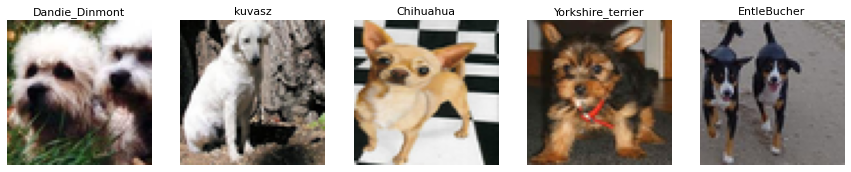

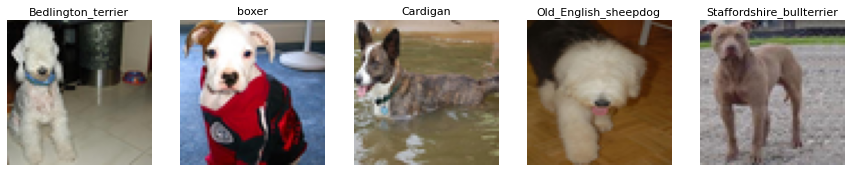

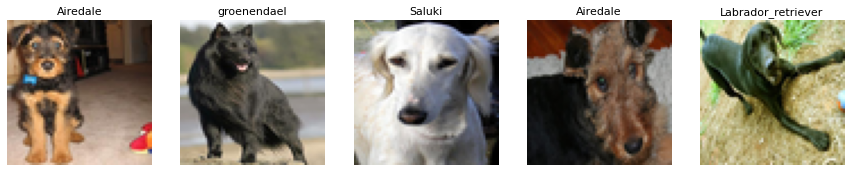

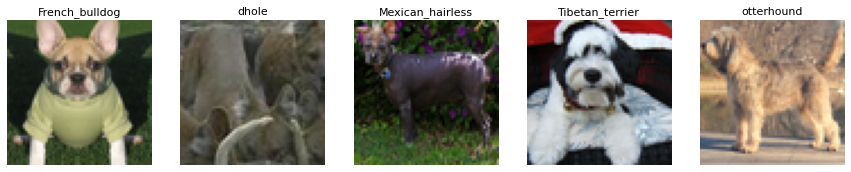

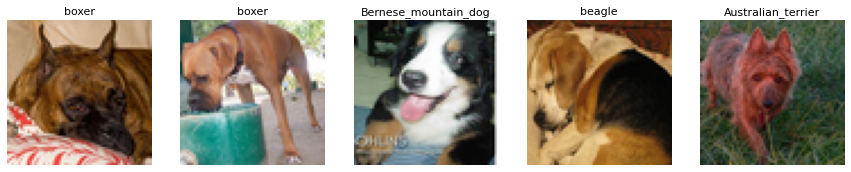

In [10]:
if dataset=="dog":
  ComputeLB = True
  DogsOnly = True

  IMAGES = {}
  ALL_IMAGES = []
  breeds = os.listdir(ANNOTATION_PATH) 

  for breed in breeds:
    IMAGES[breed] = []
    for img in os.listdir(IMAGES_PATH + '/' + breed):
      IMAGES[breed].append(img)
      ALL_IMAGES.append(img)

  idxIn = 0; namesIn = []
  imagesIn = np.zeros((25000,64,64,3))

  # CROP WITH BOUNDING BOXES TO GET DOGS ONLY
  # https://www.kaggle.com/paulorzp/show-annotations-and-breeds
  if DogsOnly:
      for breed in tqdm_notebook(breeds):
          for dog in os.listdir(ANNOTATION_PATH + '/' + breed):
              try: img = Image.open(IMAGES_PATH+'/'+breed+'/'+dog+'.jpg') 
              except: continue           
              tree = ET.parse(ANNOTATION_PATH+'/'+breed+'/'+dog)
              root = tree.getroot()
              objects = root.findall('object')
              for o in objects:
                  bndbox = o.find('bndbox') 
                  xmin = int(bndbox.find('xmin').text)
                  ymin = int(bndbox.find('ymin').text)
                  xmax = int(bndbox.find('xmax').text)
                  ymax = int(bndbox.find('ymax').text)
                  w_, h_ = img.size
                  w = np.max((xmax - xmin, ymax - ymin))
                  img2 = img.crop((xmin, ymin, min(xmin+w, w_), min(ymin+w, h_)))
                  img2 = img2.resize((64,64), Image.ANTIALIAS)
                  if np.asarray(img2).shape == (64,64,3):
                    imagesIn[idxIn,:,:,:] = np.asarray(img2)
                  if idxIn%1000==0: print(idxIn)
                  namesIn.append(breed)
                  idxIn += 1
      idx = np.arange(idxIn)
      np.random.shuffle(idx)
      imagesIn = imagesIn[idx,:,:,:]
      namesIn = np.array(namesIn)[idx]
      
  # RANDOMLY CROP FULL IMAGES
  else:
      x = np.random.choice(np.arange(20579),10000)
      for k in tqdm_notebook(range(len(x))):
        for breed in breeds:
          img = Image.open(IMAGES_PATH+"/"+breed+'/'+IMAGES[breed][0])
          w = img.size[0]
          h = img.size[1]
          sz = np.min((w,h))
          a=0; b=0
          if w<h: b = (h-sz)//2
          else: a = (w-sz)//2
          img = img.crop((0+a, 0+b, sz+a, sz+b))  
          img = img.resize((64,64), Image.ANTIALIAS)   
          imagesIn[idxIn,:,:,:] = np.asarray(img)
          namesIn.append(IMAGES[breed][0])
          if idxIn%1000==0: print(idxIn)
          idxIn += 1

  print(idxIn)
  # DISPLAY CROPPED IMAGES
  x = np.random.randint(0,idxIn,25)
  for k in range(5):
      plt.figure(figsize=(15,3))
      for j in range(5):
          plt.subplot(1,5,j+1)
          img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
          plt.axis('off')
          if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
          else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
          plt.imshow(img)
      plt.show()

In [11]:
if dataset=="dog":
    len(breeds)

In [12]:
%%time
if dataset=="dog":
    print(f'The shape of image is {imagesIn.shape}, the shape of imagename is {namesIn.shape}')
    imagesIntorch = np.array([np.array(imagesIn[i]/255.0).transpose(2, 0, 1) for i in range(idxIn)])
    print(f'The shape of reshaped image is {imagesIntorch.shape}')
    dogs = list(set(namesIn))
    len_dogs = len(dogs)
    print(f'the number of dogs is {len_dogs}')
    dog2id = {dogs[i]:i for i in range(len(dogs))}
    id2dog = {v : k for k, v in dog2id.items()}
    # print(dog2id, id2dog)
    idIn = [dog2id[name] for name in namesIn]

The shape of image is (22126, 64, 64, 3), the shape of imagename is (22126,)
The shape of reshaped image is (22126, 3, 64, 64)
the number of dogs is 120
CPU times: user 553 ms, sys: 817 ms, total: 1.37 s
Wall time: 1.37 s


In [13]:
if dataset=="dog":
    nb_images = imagesIntorch.shape[0]
    imagesIntorch.shape

### CIFAR-10

In [14]:
if dataset=="CIFAR":
    if env=="colab":
        from google.colab import drive
        drive.mount('/content/drive')
        DATA_ROOT = "/content/drive/MyDrive/3A ENSTA/Projet IA/vq-vae-2-pytorch-rosinality/data/cifar-10-batches-py/"

    if env=="kaggle":
        DATA_ROOT = "../input/cifar10/"

In [15]:
if dataset=="CIFAR":
    #!tar -xvf  '/content/drive/MyDrive/3A ENSTA/Projet IA/vq-vae-2-pytorch-rosinality/data/cifar-10-python.tar.gz' -C '/content/drive/MyDrive/3A ENSTA/Projet IA/vq-vae-2-pytorch-rosinality/data'

    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    data1 = unpickle(DATA_ROOT+'data_batch_1')
    data2 = unpickle(DATA_ROOT+'data_batch_2')
    data3 = unpickle(DATA_ROOT+'data_batch_3')
    data4 = unpickle(DATA_ROOT+'data_batch_4')
    data5 = unpickle(DATA_ROOT+'data_batch_5')
    data6 = unpickle(DATA_ROOT+'test_batch')

    data1 = data1[b'data']
    data2 = data2[b'data']
    data3 = data3[b'data']
    data4 = data4[b'data']
    data5 = data5[b'data']
    data6 = data6[b'data']

    data = np.concatenate((data1, data2), axis=0)
    data = np.concatenate((data, data3), axis=0)
    data = np.concatenate((data, data4), axis=0)
    data = np.concatenate((data, data5), axis=0)
    data = np.concatenate((data, data6), axis=0)

    imagesIntorch = torch.tensor(data)
    print("imagesIntorch", imagesIntorch.shape)
    imagesIntorch = imagesIntorch.reshape((imagesIntorch.shape[0], 3, 32, 32))
    print("imagesIntorch", imagesIntorch.shape)
    imagesIntorch = imagesIntorch.float()
    nb_images = imagesIntorch.shape[0]

## General functions

### Vector-Quantization

In [16]:
"""
Vector-Quantization for the VQ-VAE itself.
"""

def vq_loss(inputs, embedded, commitment=0.25):
    """
    Compute the codebook and commitment losses for an
    input-output pair from a VQ layer.
    """
    return (torch.mean(torch.pow(inputs.detach() - embedded, 2)) +
            commitment * torch.mean(torch.pow(inputs - embedded.detach(), 2)))


class VQ(nn.Module):
    """
    A vector quantization layer.
    This layer takes continuous inputs and produces a few
    different types of outputs, including a discretized
    output, a commitment loss, a codebook loss, etc.
    Args:
        num_channels: the depth of the input Tensors.
        num_latents: the number of latent values in the
          dictionary to choose from.
        dead_rate: the number of forward passes after
          which a dictionary entry is considered dead if
          it has not been used.
    """

    def __init__(self, num_channels, num_latents, dead_rate=100):
        super().__init__()
        self.num_channels = num_channels
        self.num_latents = num_latents
        self.dead_rate = dead_rate

        self.dictionary = nn.Parameter(torch.randn(num_latents, num_channels))
        self.usage_count = nn.Parameter(dead_rate * torch.ones(num_latents).long(),
                                        requires_grad=False)
        self._last_batch = None

    def embed(self, idxs):
        """
        Convert encoded indices into embeddings.
        Args:
            idxs: an [N x H x W] or [N] Tensor.
        Returns:
            An [N x H x W x C] or [N x C] Tensor.
        """
        embedded = F.embedding(idxs, self.dictionary)
        if len(embedded.shape) == 4:
            # NHWC to NCHW
            embedded = embedded.permute(0, 3, 1, 2).contiguous()
        return embedded

    def forward(self, inputs):
        """
        Apply vector quantization.
        If the module is in training mode, this will also
        update the usage tracker and re-initialize dead
        dictionary entries.
        Args:
            inputs: the input Tensor. Either [N x C] or
              [N x C x H x W].
        Returns:
            A tuple (embedded, embedded_pt, idxs):
              embedded: the new [N x C x H x W] Tensor
                which passes gradients to the dictionary.
              embedded_pt: like embedded, but with a
                passthrough gradient estimator. Gradients
                through this pass directly to the inputs.
              idxs: a [N x H x W] Tensor of Longs
                indicating the chosen dictionary entries.
        """
        channels_last = inputs
        if len(inputs.shape) == 4:
            # NCHW to NHWC
            channels_last = inputs.permute(0, 2, 3, 1).contiguous()

        diffs = embedding_distances(self.dictionary, channels_last)
        idxs = torch.argmin(diffs, dim=-1)
        embedded = self.embed(idxs)
        embedded_pt = embedded.detach() + (inputs - inputs.detach())

        if self.training:
            self._update_tracker(idxs)
            self._last_batch = channels_last.detach()

        return embedded, embedded_pt, idxs

    def revive_dead_entries(self, inputs=None):
        """
        Use the dictionary usage tracker to re-initialize
        entries that aren't being used often.
        Args:
          inputs: a batch of inputs from which random
            values are sampled for new entries. If None,
            the previous input to forward() is used.
        """
        if inputs is None:
            assert self._last_batch is not None, ('cannot revive dead entries until a batch has ' +
                                                  'been run')
            inputs = self._last_batch
        counts = self.usage_count.detach().cpu().numpy()
        new_dictionary = None
        inputs_numpy = None
        for i, count in enumerate(counts):
            if count:
                continue
            if new_dictionary is None:
                new_dictionary = self.dictionary.detach().cpu().numpy()
            if inputs_numpy is None:
                inputs_numpy = inputs.detach().cpu().numpy().reshape([-1, inputs.shape[-1]])
            new_dictionary[i] = random.choice(inputs_numpy)
            counts[i] = self.dead_rate
        if new_dictionary is not None:
            dict_tensor = torch.from_numpy(new_dictionary).to(self.dictionary.device)
            counts_tensor = torch.from_numpy(counts).to(self.usage_count.device)
            self.dictionary.data.copy_(dict_tensor)
            self.usage_count.data.copy_(counts_tensor)

    def _update_tracker(self, idxs):
        raw_idxs = set(idxs.detach().cpu().numpy().flatten())
        update = -np.ones([self.num_latents], dtype=np.int)
        for idx in raw_idxs:
            update[idx] = self.dead_rate
        self.usage_count.data.add_(torch.from_numpy(update).to(self.usage_count.device).long())
        self.usage_count.data.clamp_(0, self.dead_rate)


def embedding_distances(dictionary, tensor):
    """
    Compute distances between every embedding in a
    dictionary and every vector in a Tensor.
    This will not generate a huge intermediate Tensor,
    unlike the naive implementation.
    Args:
        dictionary: a [D x C] Tensor.
        tensor: a [... x C] Tensor.
    Returns:
        A [... x D] Tensor of distances.
    """
    dict_norms = torch.sum(torch.pow(dictionary, 2), dim=-1)
    tensor_norms = torch.sum(torch.pow(tensor, 2), dim=-1)

    # Work-around for https://github.com/pytorch/pytorch/issues/18862.
    exp_tensor = tensor[..., None].view(-1, tensor.shape[-1], 1)
    exp_dict = dictionary[None].expand(exp_tensor.shape[0], *dictionary.shape)
    dots = torch.bmm(exp_dict, exp_tensor)[..., 0]
    dots = dots.view(*tensor.shape[:-1], dots.shape[-1])

    return -2 * dots + dict_norms + tensor_norms[..., None]

### Encoders

In [17]:
class Encoder(nn.Module):
    """
    An abstract VQ-VAE encoder, which takes input Tensors,
    shrinks them, and quantizes the result.
    Sub-classes should overload the encode() method.
    Args:
        num_channels: the number of channels in the latent
          codebook.
        num_latents: the number of entries in the latent
          codebook.
        kwargs: arguments to pass to the VQ layer.
    """

    def __init__(self, num_channels, num_latents, **kwargs):
        super().__init__()
        self.vq = VQ(num_channels, num_latents, **kwargs)

    def encode(self, x):
        """
        Encode a Tensor before the VQ layer.
        Args:
            x: the input Tensor.
        Returns:
            A Tensor with the correct number of output
              channels (according to self.vq).
        """
        raise NotImplementedError

    def forward(self, x):
        """
        Apply the encoder.
        See VQ.forward() for return values.
        """
        return self.vq(self.encode(x))


class QuarterEncoder(Encoder):
    """
    The encoder from the original VQ-VAE paper that cuts
    the dimensions down by a factor of 4 in both
    directions.
    """

    def __init__(self, in_channels, out_channels, num_latents, **kwargs):
        super().__init__(out_channels, num_latents, **kwargs)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 4, stride=2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 4, stride=2)
        self.residual1 = _make_residual(out_channels)
        self.residual2 = _make_residual(out_channels)

    def encode(self, x):
        # Padding is uneven, so we make the right and
        # bottom more padded arbitrarily.
        x = F.pad(x, (1, 2, 1, 2))
        x = self.conv1(x)
        x = F.relu(x)
        x = F.pad(x, (1, 2, 1, 2))
        x = self.conv2(x)
        x = x + self.residual1(x)
        x = x + self.residual2(x)
        return x


class HalfEncoder(Encoder):
    """
    An encoder that cuts the input size in half in both
    dimensions.
    """

    def __init__(self, in_channels, out_channels, num_latents, **kwargs):
        super().__init__(out_channels, num_latents, **kwargs)
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)
        self.residual1 = _make_residual(out_channels)
        self.residual2 = _make_residual(out_channels)

    def encode(self, x):
        x = self.conv(x)
        x = x + self.residual1(x)
        x = x + self.residual2(x)
        return x

### Decoders

In [18]:
class Decoder(nn.Module):
    """
    An abstract VQ-VAE decoder, which takes a stack of
    (differently-sized) input Tensors and produces a
    predicted output Tensor.
    Sub-classes should overload the forward() method.
    """

    def forward(self, inputs):
        """
        Apply the decoder to a list of inputs.
        Args:
            inputs: a sequence of input Tensors. There may
              be more than one in the case of a hierarchy,
              in which case the top levels come first.
        Returns:
            A decoded Tensor.
        """
        raise NotImplementedError


class QuarterDecoder(Decoder):
    """
    The decoder from the original VQ-VAE paper that
    upsamples the dimensions by a factor of 4 in both
    directions.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.residual1 = _make_residual(in_channels)
        self.residual2 = _make_residual(in_channels)
        self.conv1 = nn.ConvTranspose2d(in_channels, in_channels, 4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)

    def forward(self, inputs):
        assert len(inputs) == 1
        x = inputs[0]
        x = x + self.residual1(x)
        x = x + self.residual2(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        return x


class HalfDecoder(Decoder):
    """
    A decoder that upsamples by a factor of 2 in both
    dimensions.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.residual1 = _make_residual(in_channels)
        self.residual2 = _make_residual(in_channels)
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)

    def forward(self, inputs):
        assert len(inputs) == 1
        #print("inputs[0] HalfEncoder",inputs[0].shape)
        x = inputs[0]
        x = x + self.residual1(x)
        x = x + self.residual2(x)
        x = F.relu(x)
        x = self.conv(x)
        return x


class HalfQuarterDecoder(Decoder):
    """
    A decoder that takes two inputs. The first one is
    upsampled by a factor of two, and then combined with
    the second input which is further upsampled by a
    factor of four.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.residual1 = _make_residual(in_channels)
        self.residual2 = _make_residual(in_channels)
        self.conv1 = nn.ConvTranspose2d(in_channels, in_channels, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels * 2, in_channels, 3, padding=1)
        self.residual3 = _make_residual(in_channels)
        self.residual4 = _make_residual(in_channels)
        self.conv3 = nn.ConvTranspose2d(in_channels, in_channels, 4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)

    def forward(self, inputs):
        assert len(inputs) == 2
        #print("inputs[0] HalfQuarterEncoder",inputs[0].shape)
        #print("inputs[1] HalfQuarterEncoder",inputs[1].shape)
        
        # Upsample the top input to match the shape of the
        # bottom input.
        x = inputs[0]
        x = x + self.residual1(x)
        x = x + self.residual2(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = F.relu(x)

        # Mix together the bottom and top inputs.
        x = torch.cat([x, inputs[1]], dim=1)
        x = self.conv2(x)

        x = x + self.residual3(x)
        x = x + self.residual4(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        return x

class HalfHalfDecoder(Decoder):
    """
    A decoder that takes two inputs. The first one is
    upsampled by a factor of two, and then combined with
    the second input which is further upsampled by a
    factor of two.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.residual1 = _make_residual(in_channels)
        self.residual2 = _make_residual(in_channels)
        self.conv1 = nn.ConvTranspose2d(in_channels, in_channels, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels * 2, in_channels, 3, padding=1)
        self.residual3 = _make_residual(in_channels)
        self.residual4 = _make_residual(in_channels)
        self.conv3 = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)

    def forward(self, inputs):
        assert len(inputs) == 2
        #print("inputs[0] HalfQuarterEncoder",inputs[0].shape)
        #print("inputs[1] HalfQuarterEncoder",inputs[1].shape)
        # Upsample the top input to match the shape of the
        # bottom input.
        x = inputs[0]
        x = x + self.residual1(x)
        x = x + self.residual2(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = F.relu(x)

        # Mix together the bottom and top inputs.
        x = torch.cat([x, inputs[1]], dim=1)
        x = self.conv2(x)

        x = x + self.residual3(x)
        x = x + self.residual4(x)
        x = F.relu(x)
        x = self.conv3(x)
        return x

### VQ-VAE

In [19]:
"""
An implementation of the hierarchical VQ-VAE.
See https://arxiv.org/abs/1906.00446.
"""

class VQVAE(nn.Module):
    """
    A complete VQ-VAE hierarchy.
    There are N encoders, stored from the bottom level to
    the top level, and N decoders stored from top to
    bottom.
    """

    def __init__(self, encoders, decoders):
        super().__init__()
        assert len(encoders) == len(decoders)
        self.encoders = encoders
        self.decoders = decoders
        for i, enc in enumerate(encoders):
            self.add_module('encoder_%d' % i, enc)
        for i, dec in enumerate(decoders):
            self.add_module('decoder_%d' % i, dec)

    def forward(self, inputs, commitment=0.25):
        """
        Compute training losses for a batch of inputs.
        Args:
            inputs: the input Tensor. If this is a Tensor
              of integers, then cross-entropy loss will be
              used for the final decoder. Otherwise, MSE
              will be used.
            commitment: the commitment loss coefficient.
        Returns:
            A dict of Tensors, containing at least:
              loss: the total training loss.
              losses: the MSE/log-loss from each decoder.
              reconstructions: a reconstruction Tensor
                from each decoder.
              embedded: outputs from every encoder, passed
                through the vector-quantization table.
                Ordered from bottom to top level.
        """
        all_encoded = [inputs]
        all_vq_outs = []
        total_vq_loss = 0.0
        total_recon_loss = 0.0
        for encoder in self.encoders:
            encoded = encoder.encode(all_encoded[-1])
            embedded, embedded_pt, _ = encoder.vq(encoded)
            all_encoded.append(encoded)
            all_vq_outs.append(embedded_pt)
            total_vq_loss = total_vq_loss + vq_loss(encoded, embedded, commitment=commitment)
        losses = []
        reconstructions = []
        for i, decoder in enumerate(self.decoders):
            dec_inputs = all_vq_outs[::-1][:i + 1]
            target = all_encoded[::-1][i + 1]
            recon = decoder(dec_inputs)
            reconstructions.append(recon)
            if target.dtype.is_floating_point:
                recon_loss = torch.mean(torch.pow(recon - target.detach(), 2))
            else:
                recon_loss = F.cross_entropy(recon.view(-1, recon.shape[-1]), target.view(-1))
            total_recon_loss = total_recon_loss + recon_loss
            losses.append(recon_loss)
        return {
            'loss': total_vq_loss + total_recon_loss,
            'losses': losses,
            'reconstructions': reconstructions,
            'embedded': all_vq_outs,
        }

    def revive_dead_entries(self):
        """
        Revive dead entries from all of the VQ layers.
        Only call this once the encoders have all been
        through a forward pass in training mode.
        """
        for enc in self.encoders:
            enc.vq.revive_dead_entries()

    def full_reconstructions(self, inputs):
        """
        Compute reconstructions of the inputs using all
        the different layers of the hierarchy.
        The first reconstruction uses only information
        from the top-level codes, the second uses only
        information from the top-level and second-to-top
        level codes, etc.
        This is not forward(inputs)['reconstructions'],
        since said reconstructions are simply each level's
        reconstruction of the next level's features.
        Instead, full_reconstructions reconstructs the
        original inputs.
        """
        terms = self(inputs)
        layer_recons = []
        for encoder, recon in zip(self.encoders[:-1][::-1], terms['reconstructions'][:-1]):
            _, embedded_pt, _ = encoder.vq(recon)
            layer_recons.append(embedded_pt)
        hierarchy_size = len(self.decoders)
        results = []
        for i in range(hierarchy_size - 1):
            num_actual = i + 1
            dec_in = terms['embedded'][-num_actual:][::-1] + layer_recons[num_actual - 1:]
            results.append(self.decoders[-1](dec_in))
        results.append(terms['reconstructions'][-1])
        return results


def _make_residual(channels):
    return nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(channels, channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(channels, channels, 1),
    )

### Scheduler

In [20]:
class CosineLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, step_size):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.step_size = step_size
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        lr = self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (
            1 + cos(self.iteration / self.step_size * pi)
        )
        self.iteration += 1

        if self.iteration == self.step_size:
            self.iteration = 0

        return [lr for base_lr in self.base_lrs]


class PowerLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, warmup):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.warmup = warmup
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        if self.iteration < self.warmup:
            lr = (
                self.lr_min + (self.lr_max - self.lr_min) / self.warmup * self.iteration
            )

        else:
            lr = self.lr_max * (self.iteration - self.warmup + 1) ** -0.5

        self.iteration += 1

        return [lr for base_lr in self.base_lrs]


class SineLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, step_size):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.step_size = step_size
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        lr = self.lr_min + (self.lr_max - self.lr_min) * sin(
            self.iteration / self.step_size * pi
        )
        self.iteration += 1

        if self.iteration == self.step_size:
            self.iteration = 0

        return [lr for base_lr in self.base_lrs]


class LinearLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, warmup, step_size):
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.step_size = step_size
        self.warmup = warmup
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        if self.iteration < self.warmup:
            lr = self.lr_max

        else:
            lr = self.lr_max + (self.iteration - self.warmup) * (
                self.lr_min - self.lr_max
            ) / (self.step_size - self.warmup)
        self.iteration += 1

        if self.iteration == self.step_size:
            self.iteration = 0

        return [lr for base_lr in self.base_lrs]


class CLR(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, step_size):
        self.epoch = 0
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.current_lr = lr_min
        self.step_size = step_size

        super().__init__(optimizer, -1)

    def get_lr(self):
        cycle = floor(1 + self.epoch / (2 * self.step_size))
        x = abs(self.epoch / self.step_size - 2 * cycle + 1)
        lr = self.lr_min + (self.lr_max - self.lr_min) * max(0, 1 - x)
        self.current_lr = lr

        self.epoch += 1

        return [lr for base_lr in self.base_lrs]


class Warmup(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, model_dim, factor=1, warmup=16000):
        self.optimizer = optimizer
        self.model_dim = model_dim
        self.factor = factor
        self.warmup = warmup
        self.iteration = 0

        super().__init__(optimizer, -1)

    def get_lr(self):
        self.iteration += 1
        lr = (
            self.factor
            * self.model_dim ** (-0.5)
            * min(self.iteration ** (-0.5), self.iteration * self.warmup ** (-1.5))
        )

        return [lr for base_lr in self.base_lrs]


# Copyright 2019 fastai

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Borrowed from https://github.com/fastai/fastai and changed to make it runs like PyTorch lr scheduler


class CycleAnnealScheduler:
    def __init__(
        self, optimizer, lr_max, lr_divider, cut_point, step_size, momentum=None
    ):
        self.lr_max = lr_max
        self.lr_divider = lr_divider
        self.cut_point = step_size // cut_point
        self.step_size = step_size
        self.iteration = 0
        self.cycle_step = int(step_size * (1 - cut_point / 100) / 2)
        self.momentum = momentum
        self.optimizer = optimizer

    def get_lr(self):
        if self.iteration > 2 * self.cycle_step:
            cut = (self.iteration - 2 * self.cycle_step) / (
                self.step_size - 2 * self.cycle_step
            )
            lr = self.lr_max * (1 + (cut * (1 - 100) / 100)) / self.lr_divider

        elif self.iteration > self.cycle_step:
            cut = 1 - (self.iteration - self.cycle_step) / self.cycle_step
            lr = self.lr_max * (1 + cut * (self.lr_divider - 1)) / self.lr_divider

        else:
            cut = self.iteration / self.cycle_step
            lr = self.lr_max * (1 + cut * (self.lr_divider - 1)) / self.lr_divider

        return lr

    def get_momentum(self):
        if self.iteration > 2 * self.cycle_step:
            momentum = self.momentum[0]

        elif self.iteration > self.cycle_step:
            cut = 1 - (self.iteration - self.cycle_step) / self.cycle_step
            momentum = self.momentum[0] + cut * (self.momentum[1] - self.momentum[0])

        else:
            cut = self.iteration / self.cycle_step
            momentum = self.momentum[0] + cut * (self.momentum[1] - self.momentum[0])

        return momentum

    def step(self):
        lr = self.get_lr()

        if self.momentum is not None:
            momentum = self.get_momentum()

        self.iteration += 1

        if self.iteration == self.step_size:
            self.iteration = 0

        for group in self.optimizer.param_groups:
            group['lr'] = lr

            if self.momentum is not None:
                group['betas'] = (momentum, group['betas'][1])

        return lr


def anneal_linear(start, end, proportion):
    return start + proportion * (end - start)


def anneal_cos(start, end, proportion):
    cos_val = cos(pi * proportion) + 1

    return end + (start - end) / 2 * cos_val


class Phase:
    def __init__(self, start, end, n_iter, anneal_fn):
        self.start, self.end = start, end
        self.n_iter = n_iter
        self.anneal_fn = anneal_fn
        self.n = 0

    def step(self):
        self.n += 1

        return self.anneal_fn(self.start, self.end, self.n / self.n_iter)

    def reset(self):
        self.n = 0

    @property
    def is_done(self):
        return self.n >= self.n_iter


class CycleScheduler:
    def __init__(
        self,
        optimizer,
        lr_max,
        n_iter,
        momentum=(0.95, 0.85),
        divider=25,
        warmup_proportion=0.3,
        phase=('linear', 'cos'),
    ):
        self.optimizer = optimizer

        phase1 = int(n_iter * warmup_proportion)
        phase2 = n_iter - phase1
        lr_min = lr_max / divider

        phase_map = {'linear': anneal_linear, 'cos': anneal_cos}

        self.lr_phase = [
            Phase(lr_min, lr_max, phase1, phase_map[phase[0]]),
            Phase(lr_max, lr_min / 1e4, phase2, phase_map[phase[1]]),
        ]

        self.momentum = momentum

        if momentum is not None:
            mom1, mom2 = momentum
            self.momentum_phase = [
                Phase(mom1, mom2, phase1, phase_map[phase[0]]),
                Phase(mom2, mom1, phase2, phase_map[phase[1]]),
            ]

        else:
            self.momentum_phase = []

        self.phase = 0

    def step(self):
        lr = self.lr_phase[self.phase].step()

        if self.momentum is not None:
            momentum = self.momentum_phase[self.phase].step()

        else:
            momentum = None

        for group in self.optimizer.param_groups:
            group['lr'] = lr

            if self.momentum is not None:
                if 'betas' in group:
                    group['betas'] = (momentum, group['betas'][1])

                else:
                    group['momentum'] = momentum

        if self.lr_phase[self.phase].is_done:
            self.phase += 1

        if self.phase >= len(self.lr_phase):
            for phase in self.lr_phase:
                phase.reset()

            for phase in self.momentum_phase:
                phase.reset()

            self.phase = 0

        return lr, momentum


class LRFinder(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, lr_min, lr_max, step_size, linear=False):
        ratio = lr_max / lr_min
        self.linear = linear
        self.lr_min = lr_min
        self.lr_mult = (ratio / step_size) if linear else ratio ** (1 / step_size)
        self.iteration = 0
        self.lrs = []
        self.losses = []

        super().__init__(optimizer, -1)

    def get_lr(self):
        lr = (
            self.lr_mult * self.iteration
            if self.linear
            else self.lr_mult ** self.iteration
        )
        lr = self.lr_min + lr if self.linear else self.lr_min * lr

        self.iteration += 1
        self.lrs.append(lr)

        return [lr for base_lr in self.base_lrs]

    def record(self, loss):
        self.losses.append(loss)

    def save(self, filename):
        with open(filename, 'w') as f:
            for lr, loss in zip(self.lrs, self.losses):
                f.write('{},{}\n'.format(lr, loss))


## Model VQ-VAE-2

In [21]:
def make_vae():
    if dataset=="dog":
        encoders = [QuarterEncoder(3, 64, 128), HalfEncoder(64, 64, 128)]
        decoders = [HalfDecoder(64, 64), HalfQuarterDecoder(64, 3)]
    if dataset=="CIFAR":
        encoders = [HalfEncoder(3, 64, 128), HalfEncoder(64, 64, 128)]
        decoders = [HalfDecoder(64, 64), HalfHalfDecoder(64, 3)]
    return VQVAE(encoders, decoders)

## Training of VQ-VAE-2

In [22]:
#!rm ./vae.pt

step 0: mse=0.004282 mse_top=0.023009
step 50: mse=0.004263 mse_top=0.023484
step 100: mse=0.004234 mse_top=0.023459
step 150: mse=0.004145 mse_top=0.023586
step 200: mse=0.004246 mse_top=0.023436
step 250: mse=0.004022 mse_top=0.022900
step 300: mse=0.004153 mse_top=0.023402
step 350: mse=0.004109 mse_top=0.023118
step 400: mse=0.004158 mse_top=0.023129
step 450: mse=0.004060 mse_top=0.022508
step 500: mse=0.003947 mse_top=0.022177
step 550: mse=0.004398 mse_top=0.023943
step 600: mse=0.004210 mse_top=0.023429
step 650: mse=0.004229 mse_top=0.022887
step 700: mse=0.004236 mse_top=0.023437
step 750: mse=0.004135 mse_top=0.023027
step 800: mse=0.004484 mse_top=0.024504
step 850: mse=0.004005 mse_top=0.021851
step 900: mse=0.004194 mse_top=0.023168
step 950: mse=0.004294 mse_top=0.023171
step 1000: mse=0.004006 mse_top=0.022407
step 1050: mse=0.004198 mse_top=0.023178
step 1100: mse=0.004019 mse_top=0.022816
step 1150: mse=0.004261 mse_top=0.023560
step 1200: mse=0.003995 mse_top=0.02251

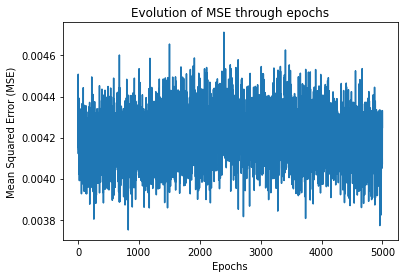

In [23]:
"""
Train a hierarchical VQ-VAE.
"""

VAE_PATH = 'vae.pt'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def main_vae():
    epochs = 5000 # init: 5000
    batch_size = 256 #16
    lr = 0.001 # init : 0.001
    device = torch.device(DEVICE)
    MSE = []

    model = make_vae()
    if os.path.exists(VAE_PATH):
        model.load_state_dict(torch.load(VAE_PATH, map_location=DEVICE))
    model.to(device)

    optimizer = optim.Adam(model.parameters())
    schedule = CycleScheduler(optimizer, lr, batch_size * epochs, momentum=(0.95, 0.85))
    
    data = load_images(batch_size = batch_size)
    for i in itertools.count():
        images = next(data).to(device)
        terms = model(images)
        mse, mse_top = terms['losses'][-1].item(), terms['losses'][0].item()
        MSE.append(mse)
        if i%50 == 0:
            print('step %d: mse=%f mse_top=%f' %
                (i, mse, mse_top))
        optimizer.zero_grad()
        terms['loss'].backward()
        schedule.step()
        optimizer.step()
        model.revive_dead_entries()
        
        if i == epochs: 
            torch.save(model.state_dict(), VAE_PATH)
            save_reconstructions(model, images)
            break

    # Display MSE
    plt.plot(MSE)
    plt.ylabel("Mean Squared Error (MSE)")
    plt.xlabel("Epochs")
    plt.title("Evolution of MSE through epochs")
    print("Final MSE :", MSE[-1])

    #return model

def save_reconstructions(vae, images):
    vae.eval()
    with torch.no_grad():
        recons = [torch.clamp(x, 0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
                  for x in vae.full_reconstructions(images)]
    vae.train()
    top_recons, real_recons = recons
    images = images.permute(0, 2, 3, 1).detach().cpu().numpy()

    columns = np.concatenate([top_recons, real_recons, images], axis=-2)
    columns = np.concatenate(columns, axis=0)
    Image.fromarray((columns * 255).astype('uint8')).save('reconstructions.png')

main_vae()

### Image reconstruction

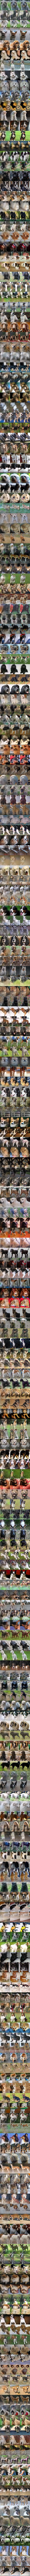

In [24]:
vae = Image.open('reconstructions.png')
vae

## Image generation

### Transformer GPT2

In [25]:
import gc

class Generator(pl.LightningModule):
    def __init__(self, hparams, load_dataset=True):
        super().__init__()
        if load_dataset:
            self.dataset = self.load_dataset(hparams)
            hparams.vocab_size = self.dataset.vocab_size
            hparams.height, hparams.width = self.dataset.shape[1:]
            hparams.max_length = self.dataset.length
            #hparams.start_token = self.dataset.start_token
        else:
            hparams.vocab_size = 256+64
            hparams.height, hparams.width = 16+4,16
            hparams.max_length = 256+64
        self.model = self.build_model(hparams)
        hparams = vars(hparams)
        for key in hparams:
            self.hparams[key] = hparams[key]
        #self.hparams.update(vars(hparams))
        #self.params = vars(hparams)
        #self.max_length = hparams.max_length

        
    def load_dataset(self, hparams):
        print("Loading the dataset of codes into memory...")
        device = "cpu"
        
        vae = make_vae()
        vae.load_state_dict(torch.load(hparams.vqvae_model_path, map_location='cuda'))
        vae.to(device)
        vae.eval()

        data = load_images(batch_size = hparams.batch_size)

        bottom_codes = []
        top_codes = []
        #codes = []
        nb = 0
        for i in itertools.count():
          print("i",i)
          print("nb",nb)
          images = next(data).to(device)
          bottom_enc = vae.encoders[0].encode(images)
          print("bottom_enc", bottom_enc.shape)
          _, _, bottom_idxs = vae.encoders[0].vq(bottom_enc)
          _, _, top_idxs = vae.encoders[1](bottom_enc)
          if nb==0:
                print('bottom_idxs', bottom_idxs.shape)
                print('top_idxs', top_idxs.shape)
          bottom_codes.append(bottom_idxs.data.cpu())
          top_codes.append(top_idxs.data.cpu())
          nb += len(bottom_idxs) # batch size ou n_embed
          if hasattr(hparams,'nb_examples') and hparams.nb_examples is not None and nb >= hparams.nb_examples:
            break
        bottom_codes = torch.cat(bottom_codes)
        top_codes = torch.cat(top_codes)
        print('Bottom code shape', bottom_codes.shape, type(bottom_codes),'min',bottom_codes.min(),'max', bottom_codes.max())
        print('Top code shape', top_codes.shape, type(top_codes),'min',top_codes.min(),'max', top_codes.max())
        #print(np.unique(codes))
        if hparams.nb_examples and len(bottom_codes) >= hparams.nb_examples:
            bottom_codes = bottom_codes[:hparams.nb_examples]
            top_codes = top_codes[:hparams.nb_examples]

        #vocab_size = vae.model.num_embeddings + 1
        #start_token = vae.model.num_embeddings
        #vocab_size =  256 #257, 65
        #start_token = 256 #256, 64
        bottom_codes_ = bottom_codes.view(len(bottom_codes), -1)
        top_codes_ = top_codes.view(len(top_codes), -1)
        codes_ = torch.cat((bottom_codes_,top_codes_),1)
        print('codes_', codes_.shape)
        #print('codes_', codes_)
        codes_ = codes_.long()
        #print('codes_ after long()', codes_)
        #codes_ = torch.cat([(torch.ones(len(codes_), 1).long() * start_token), codes_.long(),], dim=1)
        print('codes_', codes_.shape)

        dataset = TensorDataset(codes_)
        dataset.vocab_size = codes_.shape[1]
        print('vocab_size', dataset.vocab_size)
        dataset.shape = (bottom_codes.shape[0], int(bottom_codes.shape[1]+top_codes.shape[1]/2), bottom_codes.shape[2])
        print('shape', dataset.shape)
        dataset.length = codes_.shape[1]
        print('length', dataset.length)
        #dataset.start_token = start_token
        #print('start_token', start_token)
        print("Done loading dataset")
        
        del codes_
        #del codes
        del bottom_codes
        del top_codes
        del bottom_idxs
        del top_idxs
        torch.cuda.empty_cache()
        gc.collect()
        
        return dataset

    def forward(self, x):
        return self.model(x)

    def build_model(self, hparams):
        config = GPT2Config(vocab_size=hparams.vocab_size, 
                            n_positions=hparams.max_length, 
                            n_ctx=hparams.max_length, 
                            n_embd=256, # 256
                            n_layer=4, 
                            n_head=4, 
                            resid_pdrop=0.2,
                            embd_pdrop=0.2,
                            attn_pdrop=0.2)
        return GPT2LMHeadModel(config)

    def generate(self, nb_examples=1, **kwargs):
        hparams = Namespace(**self.hparams)
        input_ids = cudafy(torch.randint(0,self.hparams.vocab_size, (nb_examples, 1)).long())
        #input_ids = torch.zeros(nb_examples, 1).long().to(self.device)
        #input_ids[:] = hparams.vocab_size - 1
        #input_ids[:] = hparams.vocab_size
        result = self.model.generate(input_ids, max_length=hparams.max_length, **kwargs)
        print(result.shape,'output of model')
        #result = result[:, 1:]
        result = result.contiguous()
        print(result.shape,'output of model')
        #print(result.shape, 'result after reshaping')
        result = result.view(nb_examples, hparams.height, hparams.width)
        print(result.shape,'output of model')
        del input_ids
        torch.cuda.empty_cache()
        gc.collect()
        return result

    def training_step(self, batch, batch_idx):
        (X,) = batch
        #print("X.shape", X.shape)
        outputs = self.model(X, labels=X)
        loss = outputs.loss
        #print("loss", loss)
        output = OrderedDict({"loss": loss, "log": {"loss": loss,},})
        #print("output", output)
        del outputs, loss
        torch.cuda.empty_cache()
        gc.collect()
        return output

    def train_dataloader(self):
        hparams = Namespace(**self.hparams)
        #del self.dataset
        #torch.cuda.empty_cache()
        #gc.collect()
        return torch.utils.data.DataLoader(self.dataset, batch_size=hparams.batch_size, shuffle=True, num_workers=hparams.num_workers)

    def configure_optimizers(self):
        hparams = Namespace(**self.hparams)
        optimizer = optim.Adam(self.parameters(),lr=hparams.lr, weight_decay=hparams.weight_decay)
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=hparams.scheduler_gamma)
        return [optimizer], [scheduler]

### PixelCNN

In [26]:
"""
An implementation of multi-head attention, based off of
https://github.com/unixpickle/xformer
"""

class PixelAttention(nn.Module):
    """
    An attention layer that operates on images.
    Args:
        num_channels: the input image depth.
        num_heads: the number of attention heads.
    """

    def __init__(self, num_channels, num_heads=8):
        super().__init__()
        self.attention = MaskedAttention(num_channels, num_heads=num_heads)

    def forward(self, *images, conds=None):
        """
        Apply masked attention to a batch of images.
        Args:
            images: one or more [N x C x H x W] Tensors.
            conds: ignored. Here for compatibility with
              the PixelCNN aggregator.
        Returns:
            A new list of [N x C x H x W] Tensors.
        """
        results = []
        for image in images:
            batch, num_channels, height, width = image.shape
            result = image.permute(0, 2, 3, 1)
            result = result.view(batch, height * width, num_channels)
            result = self.attention(result)
            result = result.view(batch, height, width, num_channels)
            result = result.permute(0, 3, 1, 2)
            results.append(result + image)
        if len(results) == 1:
            return results[0]
        return tuple(results)


class MaskedAttention(nn.Module):
    """
    An attention layer that operates on sequences of the
    shape [N x T x C], where N is the batch size, T is the
    number of timesteps, and C is the number of channels.
    Args:
        num_channels: the number of channels in the input
          sequences.
        num_heads: the number of attention heads to use.
    """

    def __init__(self, num_channels, num_heads=8):
        super().__init__()

        assert not num_channels % num_heads, 'heads must evenly divide channels'
        self.num_channels = num_channels
        self.num_heads = num_heads

        self.kqv_projection = nn.Linear(num_channels, num_channels * 3)
        self.mix_heads = nn.Linear(num_channels, num_channels)

    def forward(self, sequence):
        """
        Apply masked multi-head attention.
        Args:
            sequence: an [N x T x C] Tensor.
        Returns:
            A new [N x T x C] Tensor.
        """
        projected = self.kqv_projection(sequence)
        kqv = torch.split(projected, self.num_channels, dim=-1)
        keys, queries, values = [self._split_heads(x) for x in kqv]
        logits = torch.bmm(queries, keys.permute(0, 2, 1))
        logits /= math.sqrt(self.num_channels / self.num_heads)
        logits += self._logit_mask(sequence.shape[1])
        weights = F.softmax(logits, dim=-1)
        weighted_sum = torch.bmm(weights, values)
        combined = self._combine_heads(weighted_sum)
        return self.mix_heads(combined)

    def _split_heads(self, batch):
        """
        Split up the channels in a batch into groups, one
        per head.
        Args:
            batch: an [N x T x C] Tensor.
        Returns:
            An [N*H x T x C/H] Tensor.
        """
        batch_size = batch.shape[0]
        num_steps = batch.shape[1]
        split_channels = self.num_channels // self.num_heads
        batch = batch.view(batch_size, num_steps, self.num_heads, split_channels)
        batch = batch.permute(0, 2, 1, 3).contiguous()
        batch = batch.view(batch_size * self.num_heads, num_steps, split_channels)
        return batch

    def _combine_heads(self, batch):
        """
        Perform the inverse of _split_heads().
        Args:
            batch: an [N*H x T x C/H] Tensor.
        Returns:
            An [N x T x C] Tensor.
        """
        batch_size = batch.shape[0] // self.num_heads
        num_steps = batch.shape[1]
        split_channels = self.num_channels // self.num_heads
        batch = batch.view(batch_size, self.num_heads, num_steps, split_channels)
        batch = batch.permute(0, 2, 1, 3).contiguous()
        batch = batch.view(batch_size, num_steps, self.num_channels)
        return batch

    def _logit_mask(self, num_steps):
        row_indices = np.arange(num_steps)[:, None]
        col_indices = np.arange(num_steps)[None]
        upper = (row_indices >= col_indices)
        mask = np.where(upper, 0, -np.inf).astype(np.float32)
        return torch.from_numpy(mask).to(next(self.parameters()).device)

In [27]:
"""
An implementation of the Gated PixelCNN from
https://arxiv.org/abs/1606.05328.
"""

class PixelCNN(nn.Module):
    """
    A PixelCNN is a stack of PixelConv layers.
    """

    def __init__(self, *layers):
        super().__init__()
        for i, layer in enumerate(layers):
            self.add_module('layer_%d' % i, layer)
        self.layers = layers

    def forward(self, images, conds=None):
        """
        Apply the stack of PixelConv layers.
        It is assumed that the first layer is a
        PixelConvA, and the rest are PixelConvB's.
        This way, the first layer takes one input and the
        rest take two.
        Returns:
            A tuple (vertical, horizontal), one for each
              of the two directional stacks.
        """
        outputs = self.layers[0](images, conds=conds)
        for layer in self.layers[1:]:
            outputs = layer(*outputs, conds=conds)
        return outputs


class PixelConv(nn.Module):
    """
    An abstract base class for PixelCNN layers.
    """

    def __init__(self, depth_in, depth_out, cond_depth=None, horizontal=2, vertical=2):
        super().__init__()
        self.depth_in = depth_in
        self.depth_out = depth_out
        self.horizontal = horizontal
        self.vertical = vertical

        self._init_directional_convs()
        self.vert_to_horiz = nn.Conv2d(depth_out * 2, depth_out * 2, 1)
        self.cond_layer = None
        if cond_depth is not None:
            self.cond_layer = nn.Linear(cond_depth, depth_out * 4)

    def _init_directional_convs(self):
        raise NotImplementedError

    def _run_stacks(self, vert_in, horiz_in, conds):
        vert_out = self._run_padded_vertical(vert_in)
        horiz_out = self._run_padded_horizontal(horiz_in)
        horiz_out = horiz_out + self.vert_to_horiz(vert_out)

        if conds is not None:
            cond_bias = self._compute_cond_bias(conds)
            vert_out = vert_out + cond_bias[:, :self.depth_out*2]
            horiz_out = horiz_out + cond_bias[:, self.depth_out*2:]

        vert_out = gated_activation(vert_out)
        horiz_out = gated_activation(horiz_out)
        return vert_out, horiz_out

    def _run_padded_vertical(self, vert_in):
        raise NotImplementedError

    def _run_padded_horizontal(self, horiz_in):
        raise NotImplementedError

    def _compute_cond_bias(self, conds):
        if len(conds.shape) == 2:
            outputs = self.cond_layer(conds)
            return outputs.view(-1, outputs.shape[1], 1, 1)
        assert len(conds.shape) == 4
        conds_perm = conds.permute(0, 2, 3, 1)
        outputs = self.cond_layer(conds_perm)
        return outputs.permute(0, 3, 1, 2)


class PixelConvA(PixelConv):
    """
    The first layer in a PixelCNN. This layer is unlike
    the other layers, in that it does not allow the stack
    to see the current pixel.
    Args:
        depth_in: the number of input filters.
        depth_out: the number of output filters.
        cond_depth: the number of conditioning channels.
          If None, this is an unconditional model.
        horizontal: the receptive field of the horizontal
          stack.
        vertical: the receptive field of the vertical
          stack.
    """

    def __init__(self, depth_in, depth_out, cond_depth=None, horizontal=2, vertical=2):
        super().__init__(depth_in, depth_out, cond_depth=cond_depth, horizontal=2, vertical=2)

    def forward(self, images, conds=None):
        """
        Apply the layer to some images, producing latents.
        Args:
            images: an NCHW batch of images.
            conds: an optional conditioning value. If set,
              either an NCHW Tensor or an NxM Tensor.
        Returns:
            A tuple (vertical, horizontal), one for each
              of the two directional stacks.
        """
        return self._run_stacks(images, images, conds)

    def _init_directional_convs(self):
        self.vertical_conv = nn.Conv2d(self.depth_in, self.depth_out * 2,
                                       (self.vertical, self.horizontal*2 + 1))
        self.horizontal_conv = nn.Conv2d(self.depth_in, self.depth_out * 2, (1, self.horizontal))

    def _run_padded_vertical(self, vert_in):
        vert_pad = (self.horizontal, self.horizontal, self.vertical, 0)
        return self.vertical_conv(F.pad(vert_in, vert_pad))[:, :, :-1, :]

    def _run_padded_horizontal(self, horiz_in):
        return self.horizontal_conv(F.pad(horiz_in, (self.horizontal, 0, 0, 0)))[:, :, :, :-1]


class PixelConvB(PixelConv):
    """
    Any layer except the first in a PixelCNN.
    Args:
        depth_in: the number of input filters.
        cond_depth: the number of conditioning channels.
          If None, this is an unconditional model.
        horizontal: the receptive field of the horizontal
          stack.
        vertical: the receptive field of the vertical
          stack.
    """

    def __init__(self, depth_in, cond_depth=None, norm=False, horizontal=2, vertical=2):
        super().__init__(depth_in, depth_in, cond_depth=cond_depth, horizontal=horizontal,
                         vertical=vertical)
        self.horiz_residual = nn.Conv2d(depth_in, depth_in, 1)
        self.vert_norm = lambda x: x
        self.horiz_norm = lambda x: x
        if norm:
            self.vert_norm = ChannelNorm(depth_in)
            self.horiz_norm = ChannelNorm(depth_in)

    def forward(self, vert_in, horiz_in, conds=None):
        """
        Apply the layer to the outputs of previous
        vertical and horizontal stacks.
        Args:
            vert_in: an NCHW Tensor.
            horiz_in: an NCHW Tensor.
            conds: an optional conditioning value. If set,
              either an NCHW Tensor or an NxM Tensor.
        Returns:
            A tuple (vertical, horizontal), one for each
              of the two directional stacks.
        """
        vert_out, horiz_out = self._run_stacks(vert_in, horiz_in, conds)
        horiz_out = horiz_in + self.horiz_norm(self.horiz_residual(horiz_out))
        return self.vert_norm(vert_out), horiz_out

    def _init_directional_convs(self):
        self.vertical_conv = nn.Conv2d(self.depth_in, self.depth_out * 2,
                                       (self.vertical + 1, self.horizontal*2 + 1))
        self.horizontal_conv = nn.Conv2d(self.depth_in, self.depth_out * 2,
                                         (1, self.horizontal + 1))

    def _run_padded_vertical(self, vert_in):
        vert_pad = (self.horizontal, self.horizontal, self.vertical, 0)
        return self.vertical_conv(F.pad(vert_in, vert_pad))

    def _run_padded_horizontal(self, horiz_in):
        return self.horizontal_conv(F.pad(horiz_in, (self.horizontal, 0, 0, 0)))


class ChannelNorm(nn.Module):
    """
    A layer which applies layer normalization to the
    channels at each spacial location separately.
    """

    def __init__(self, num_channels):
        super().__init__()
        self.norm = nn.LayerNorm((num_channels,))

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = self.norm(x)
        x = x.permute(0, 3, 1, 2).contiguous()
        return x


def gated_activation(outputs):
    depth = outputs.shape[1] // 2
    tanh = torch.tanh(outputs[:, :depth])
    sigmoid = torch.sigmoid(outputs[:, depth:])
    return tanh * sigmoid

In [28]:
"""
Models for hierarchical image generation.
"""

class TopPrior(nn.Module):
    def __init__(self, depth=64, num_heads=2):
        super().__init__()
        self.embed = nn.Embedding(128, depth)
        self.pixel_cnn = PixelCNN(
            PixelConvA(depth, depth),

            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelAttention(depth, num_heads=num_heads),

            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelAttention(depth, num_heads=num_heads),

            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelAttention(depth, num_heads=num_heads),

            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelConvB(depth, norm=True),
            PixelAttention(depth, num_heads=num_heads),
        )
        self.out_stack = nn.Sequential(
            nn.Conv2d(depth * 2, depth, 1),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            Residual1x1(depth),
            nn.Conv2d(depth, 256, 1),
        )

    def forward(self, x):
        x = self.embed(x)
        x = x.permute(0, 3, 1, 2).contiguous()
        out1, out2 = self.pixel_cnn(x)
        return self.out_stack(torch.cat([out1, out2], dim=1))


class BottomPrior(nn.Module):
    def __init__(self, depth=64, num_heads=2):
        super().__init__()
        self.embed_top = nn.Embedding(128, depth)
        self.embed_bottom = nn.Embedding(128, depth)
        self.cond_stack = nn.Sequential(
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            Residual3x3(depth),
            nn.ConvTranspose2d(depth, depth, 4, stride=2, padding=1),
        )
        self.pixel_cnn = PixelCNN(
            PixelConvA(depth, depth, cond_depth=depth),

            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),

            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),

            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),

            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
            PixelConvB(depth, cond_depth=depth, norm=True),
        )
        self.out_stack = nn.Sequential(
            nn.Conv2d(depth * 2, depth, 1),
            nn.Conv2d(depth, 128, 1),
        )

    def forward(self, bottom, top):
        conds = self.embed_top(top)
        conds = conds.permute(0, 3, 1, 2).contiguous()
        conds = self.cond_stack(conds)

        out = self.embed_bottom(bottom)
        out = out.permute(0, 3, 1, 2).contiguous()
        out1, out2 = self.pixel_cnn(out, conds=conds)
        return self.out_stack(torch.cat([out1, out2], dim=1))


class Residual1x1(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, 1)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 1)
        self.norm = ChannelNorm(num_channels)

    def forward(self, x):
        inputs = x
        x = F.relu(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        return inputs + self.norm(x)


class Residual3x3(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 3, padding=1)
        self.norm = ChannelNorm(num_channels)

    def forward(self, x):
        inputs = x
        x = F.relu(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        return inputs + self.norm(x)

### Training of generation model

In [29]:
if generation_model=="transformer":
    def train_transformer_generator(hparams):
        torch.cuda.empty_cache()
        hparams = Namespace(**hparams)
        generator = Generator(hparams, load_dataset=True)
        #logger = pl.loggers.TensorBoardLogger(save_dir=hparams.folder, name="logs")
        trainer = pl.Trainer(#default_root_dir=hparams.folder, 
                             enable_checkpointing=False,
                             #weights_save_path=hparams.folder+'/checkpoints',
                             max_epochs=hparams.epochs,
                             enable_progress_bar=True,
                             gpus=hparams.gpus,
                             #logger=logger,
                             #resume_from_checkpoint=hparams.resume_from_checkpoint,
                             detect_anomaly=True)
        trainer.fit(generator) #, ckpt_path=hparams.resume_from_checkpoint)
        return generator, trainer

    hparams = {'resume_from_checkpoint': None,
            #'folder': '/out/generator', 
            'epochs': 5, #200  
            'lr': 1e-3, 
            'weight_decay': 0, 
            'scheduler_gamma':  1, 
            'batch_size': 128, # ok : 32, 64, 128 / not ok : 256
            'num_workers': 1, 
            'nb_examples':2000, #nb_images
            'vqvae_model_path':VAE_PATH, 
            'gpus': 1 if torch.cuda.is_available() else 0}
    generator, trainergenerator = train_transformer_generator(hparams=hparams)

Loading the dataset of codes into memory...
i 0
nb 0
bottom_enc torch.Size([128, 64, 16, 16])
bottom_idxs torch.Size([128, 16, 16])
top_idxs torch.Size([128, 8, 8])
i 1
nb 128
bottom_enc torch.Size([128, 64, 16, 16])
i 2
nb 256
bottom_enc torch.Size([128, 64, 16, 16])
i 3
nb 384
bottom_enc torch.Size([128, 64, 16, 16])
i 4
nb 512
bottom_enc torch.Size([128, 64, 16, 16])
i 5
nb 640
bottom_enc torch.Size([128, 64, 16, 16])
i 6
nb 768
bottom_enc torch.Size([128, 64, 16, 16])
i 7
nb 896
bottom_enc torch.Size([128, 64, 16, 16])
i 8
nb 1024
bottom_enc torch.Size([128, 64, 16, 16])
i 9
nb 1152
bottom_enc torch.Size([128, 64, 16, 16])
i 10
nb 1280
bottom_enc torch.Size([128, 64, 16, 16])
i 11
nb 1408
bottom_enc torch.Size([128, 64, 16, 16])
i 12
nb 1536
bottom_enc torch.Size([128, 64, 16, 16])
i 13
nb 1664
bottom_enc torch.Size([128, 64, 16, 16])
i 14
nb 1792
bottom_enc torch.Size([128, 64, 16, 16])
i 15
nb 1920
bottom_enc torch.Size([128, 64, 16, 16])
Bottom code shape torch.Size([2048, 16, 1

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Missing logger folder: /home/group6IA/vqvae/lightning_logs

  | Name  | Type            | Params
------------------------------------------
0 | model | GPT2LMHeadModel | 3.3 M 
------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.294    Total estimated model params size (MB)
/home/group6IA/miniconda3/envs/vqvae/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/group6IA/miniconda3/envs/vqvae/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loa

Training: 0it [00:00, ?it/s]

/home/group6IA/miniconda3/envs/vqvae/lib/python3.8/site-packages/pytorch_lightning/loops/optimization/closure.py:35: LightningDeprecationWarning: One of the returned values {'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprecation(


In [30]:
"""
Train the top-level prior.
"""

if generation_model=="pixelCNN":
  TOP_PRIOR_PATH = 'top.pt'

  def main_top():
      epochs = 10000 # 60000
      batch_size = 64
      lr = 3e-4
      device = torch.device(DEVICE)
      LOSS = []

      vae = make_vae()
      vae.load_state_dict(torch.load(VAE_PATH, map_location='cpu'))
      vae.to(device)
      vae.eval()

      top_prior = TopPrior()
      if os.path.exists(TOP_PRIOR_PATH):
          top_prior.load_state_dict(torch.load(TOP_PRIOR_PATH, map_location='cuda'))
      top_prior.to(device)

      optimizer = optim.Adam(top_prior.parameters(), lr=lr)
      loss_fn = nn.CrossEntropyLoss()
      
      schedule = CycleScheduler(optimizer, lr, batch_size * epochs, momentum=(0.95, 0.85),)
      data = load_images(batch_size = batch_size)
      for i in itertools.count():
          images = next(data).to(device)
          _, _, encoded = vae.encoders[1](vae.encoders[0].encode(images))
          logits = top_prior(encoded)
          logits = logits.permute(0, 2, 3, 1).contiguous()
          logits = logits.view(-1, logits.shape[-1])
          loss = loss_fn(logits, encoded.view(-1))
          LOSS.append(loss)
          if i%100 == 0:
            print('step %d: loss=%f' % (i, loss.item()))
          optimizer.zero_grad()
          loss.backward()
          schedule.step()
          optimizer.step()
          if not i % 30:
              torch.save(top_prior.state_dict(), TOP_PRIOR_PATH)
              
          if i == epochs: break
      
      # Display loss
      plt.plot(LOSS)
      plt.ylabel("Loss")
      plt.xlabel("Epochs")
      plt.title("Evolution of the loss through epochs")


  main_top()

In [31]:
"""
Train the bottom-level prior.
"""

if generation_model=="pixelCNN":
  BOTTOM_PRIOR_PATH = 'bottom.pt'

  def main_bottom():
      epochs = 4700 # 60000
      batch_size = 64
      lr = 3e-4
      device = torch.device(DEVICE)
      LOSS = []

      vae = make_vae()
      vae.load_state_dict(torch.load(VAE_PATH, map_location='cuda'))
      vae.to(device)
      vae.eval()

      bottom_prior = BottomPrior()
      if os.path.exists(BOTTOM_PRIOR_PATH):
          bottom_prior.load_state_dict(torch.load(BOTTOM_PRIOR_PATH, map_location='cuda'))
      bottom_prior.to(device)

      optimizer = optim.Adam(bottom_prior.parameters(), lr=lr)
      loss_fn = nn.CrossEntropyLoss()

      schedule = CycleScheduler(optimizer, lr, batch_size * epochs, momentum=(0.95, 0.85),)
      data = load_images(batch_size = batch_size)
      for i in itertools.count():
          images = next(data).to(device)
          bottom_enc = vae.encoders[0].encode(images)
          _, _, bottom_idxs = vae.encoders[0].vq(bottom_enc)
          _, _, top_idxs = vae.encoders[1](bottom_enc)
          logits = bottom_prior(bottom_idxs, top_idxs)
          logits = logits.permute(0, 2, 3, 1).contiguous()
          logits = logits.view(-1, logits.shape[-1])
          loss = loss_fn(logits, bottom_idxs.view(-1))
          LOSS.append(loss)
          if i%100 == 0:
            print('step %d: loss=%f' % (i, loss.item()))
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if not i % 30:
              torch.save(bottom_prior.state_dict(), BOTTOM_PRIOR_PATH)
          if i == epochs: break

      # Display loss
      plt.plot(LOSS)
      plt.ylabel("Loss")
      plt.xlabel("Epochs")
      plt.title("Evolution of the loss through epochs")

  main_bottom()

### Random generation

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


torch.Size([2, 320]) output of model
torch.Size([2, 320]) output of model
torch.Size([2, 20, 16]) output of model
result_idxs torch.Size([2, 20, 16])
max(result_idxs) tensor(124, device='cuda:0')
max(result_idxs) tensor(124, device='cuda:0')
bottom_idxs torch.Size([2, 16, 16])
top_idxs torch.Size([2, 4, 16])
top_idxs torch.Size([2, 64])
top_idxs torch.Size([2, 8, 8])
bottom_generated torch.Size([2, 64, 16, 16])
top_generated torch.Size([2, 64, 8, 8])
generated.shape torch.Size([2, 3, 64, 64])


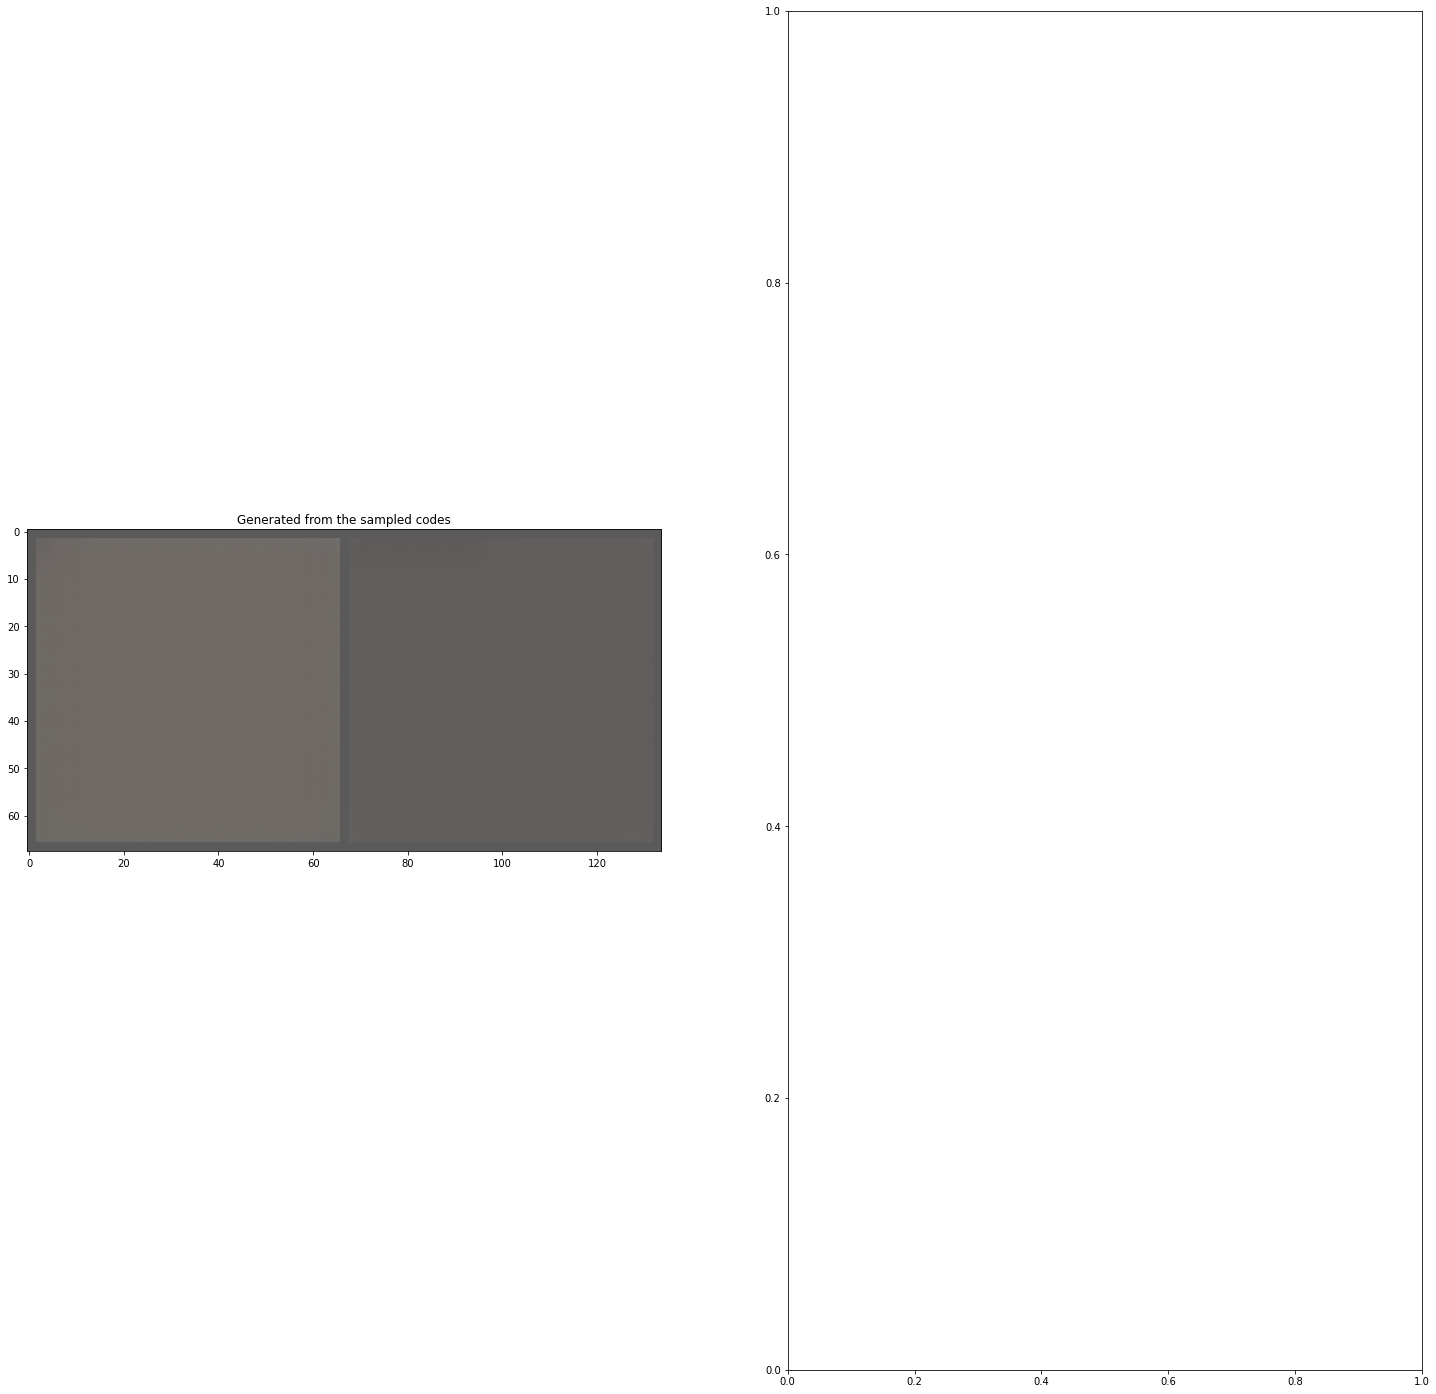

In [32]:
if generation_model=="transformer":
    GENERATOR_PATH = '/generator/logs/version_1/checkpoints/epoch=18.ckpt'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    #DEVICE = 'cpu'

    def random_generate_from_GPT2(generator, path_generator=GENERATOR_PATH, path_vqvae=VAE_PATH, nb_examples=2):
        vae = make_vae()
        vae.load_state_dict(torch.load(path_vqvae, map_location='cuda'))
        vae.to(DEVICE)
        vae.eval()

        #generator = Generator.load_from_checkpoint(path_generator)
        generator = cudafy(generator)
        #generator.eval()

        #input_ids = cudafy(torch.randint(0,generator.hparams.vocab_size-1, (nb_examples**2, 1)).long())
        result_idxs = generator.generate(nb_examples=nb_examples)
        print("result_idxs", result_idxs.shape)
        print("max(result_idxs)", torch.max(result_idxs))
        #result_idxs[result_idxs>=generator.hparams.vocab_size-1] = generator.hparams.vocab_size-2
        result_idxs[result_idxs>=generator.hparams.vocab_size] = generator.hparams.vocab_size-1
        print("max(result_idxs)", torch.max(result_idxs))
        bottom_idxs = result_idxs[:,:16,:]
        print("bottom_idxs", bottom_idxs.shape)
        top_idxs = result_idxs[:,16:,:]
        print("top_idxs", top_idxs.shape)
        top_idxs = top_idxs.view(len(top_idxs), -1)
        print("top_idxs", top_idxs.shape)
        top_idxs = top_idxs.reshape((len(top_idxs),8,8))
        print("top_idxs", top_idxs.shape)
        bottom_generated = vae.encoders[0].vq.embed(bottom_idxs)
        top_generated = vae.encoders[1].vq.embed(top_idxs)
        print("bottom_generated", bottom_generated.shape)
        print("top_generated", top_generated.shape)

        with torch.no_grad():
            generated = vae.decoders[1]([top_generated,bottom_generated])
            #generated = vae.decoders[0]([torch.rand(nb_examples,64,8,8)])
            print("generated.shape", generated.shape)
            #generated = vae.reconstruct_from_code(result)

            fig, axes = plt.subplots(1,2, figsize=(25,25))
            img = make_grid(generated, nb_examples).permute(1,2,0)*0.1352 + 0.3541
            axes[0].imshow(cudafy.get(img).detach().cpu().numpy())
            axes[0].set_title('Generated from the sampled codes')
            vae.eval()

            #recon = vae(generated)["reconstructions"]
            #img = make_grid(recon, nb_examples).permute(1,2,0)*0.1352 + 0.3541
            #axes[1].imshow(cudafy.get(img).detach().cpu().numpy())
            #axes[1].set_title('Reconstructed from the generated images')

    random_generate_from_GPT2(generator, nb_examples=2)

In [33]:
"""
Generate samples using the top-level prior.
"""

if generation_model=="pixelCNN":
  NUM_SAMPLES = 4

  def main_sample():
      device = torch.device(DEVICE)

      vae = make_vae()
      vae.load_state_dict(torch.load(VAE_PATH))
      vae.to(device)
      vae.eval()

      top_prior = TopPrior()
      top_prior.load_state_dict(torch.load(TOP_PRIOR_PATH))
      top_prior.to(device)

      results = np.zeros([NUM_SAMPLES, 8, 8], dtype=np.long)
      for row in range(results.shape[1]):
          for col in range(results.shape[2]):
              partial_in = torch.from_numpy(results[:, :row + 1]).to(device)
              with torch.no_grad():
                  outputs = torch.softmax(top_prior(partial_in), dim=1).cpu().numpy()
              for i, out in enumerate(outputs):
                  probs = out[:, row, col]
                  results[i, row, col] = sample_softmax(probs)
          print('done row', row)
      with torch.no_grad():
          full_latents = torch.from_numpy(results).to(device)
          top_embedded = vae.encoders[1].vq.embed(full_latents)
          bottom_encoded = vae.decoders[0]([top_embedded])
          bottom_embedded, _, _ = vae.encoders[0].vq(bottom_encoded)
          decoded = torch.clamp(vae.decoders[1]([top_embedded, bottom_embedded]), 0, 1)
      decoded = decoded.permute(0, 2, 3, 1).cpu().numpy()
      decoded = np.concatenate(decoded, axis=1)
      Image.fromarray((decoded * 255).astype(np.uint8)).save('top_samples.png')


  def sample_softmax(probs):
      number = random.random()
      for i, x in enumerate(probs):
          number -= x
          if number <= 0:
              return i
      return len(probs) - 1


  def arg_parser():
      parser = argparse.ArgumentParser()
      parser.add_argument('--device', help='torch device', default='cuda')
      return parser

  main_sample()
  samples = Image.open('top_samples.png')
  samples